In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
#from transformers import pipeline

import pandas as pd

from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch

from transformers import AdamW

from sklearn.model_selection import train_test_split
import random

from torch.utils.data import DataLoader

from transformers import get_scheduler
from tqdm.auto import tqdm

import os
import time
import numpy as np
import matplotlib.pyplot as plt


## load dataset, prepare Haiku

In [ ]:
%cd /content/drive/MyDrive/3rd Year/ECE4179 Neural Network/course_project
!ls

/content/drive/MyDrive/3rd Year/ECE4179 Neural Network/course_project
'Copy of Haiku Generator with BERT.gdoc'   models
 course_project.pdf			   Presentation.gslides
 haiku_data				   Report.gdoc
 Haiku_extractor.ipynb			   RoBERTa_haiku.ipynb
'Haiku Generator with BERT.gdoc'	   Tuned_model_test.ipynb


In [ ]:
df = pd.read_csv("haiku_data", usecols=[1]) 
#haiku = df.iloc[0]
#haiku = str(haiku)
print(df.shape)
print(df['haiku'].shape)

(11370, 1)
(11370,)


In [ ]:
# break up haiku into train and validate data
#https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
train, validate = train_test_split(df, test_size=0.2)
validate, test = train_test_split(validate, test_size=0.5)
print(train.shape)
print(validate.shape)
print(test.shape)
# show the data to show the split occurs randomly

(9096, 1)
(1137, 1)
(1137, 1)


In [ ]:
# mask input haiku
# average haiku length in the dataset is 8. mask 40% of the haiku to get 3 words
def random_mask(sent):
  words = sent.split()
  for i in range(len(words)):
    random_value = random.randint(0, 10)
    #0,1,2,3,4,5,6,7,8,9. 40% of chance to get value greater than 5
    if random_value > 5:
      words[i] = '<mask>'
  # this can remove the unnecessary space between words in haiku e.g. "an  apple"
  sent = ' '.join(words)
  #sent = sent.join("</s>")
  return sent

# function to delete the unnecessary space between words in haiku e.g. "an  apple"
def reformat(sent):
  words = sent.split()
  sent = ' '.join(words)
  return sent

# redefine mask and label
train_masked = [random_mask(sent) for sent in train['haiku']]
train_label = [reformat(sent) for sent in train['haiku']]
validate_masked = [random_mask(sent) for sent in validate['haiku']]
validate_label = [reformat(sent) for sent in validate['haiku']]
test_masked = [random_mask(sent) for sent in test['haiku']]
test_label = [reformat(sent) for sent in test['haiku']]

In [ ]:
print(train_masked[0])
print(train_label[0])

<mask> charcoal <mask> <mask> <mask> peace of mind
weighing charcoal one measure buys peace of mind


# DeepLearning starts here

### tokenize haiku

In [ ]:
# data loader 
#train_dataloader = DataLoader(train_masked_tokenized, batch_size=batch_size)
#eval_dataloader = DataLoader(validate_masked_tokenized, batch_size=batch_size)

In [ ]:
#del model
torch.cuda.empty_cache()

In [ ]:
# initiallise model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained('roberta-base')

# optimiser 
optimizer = AdamW(model.parameters(), lr=5e-5)
# GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

batch_size = 16
num_epochs = 4

In [ ]:
train_masked_tokenized = [tokenizer(sent, return_tensors="pt") for sent in train_masked]
print(len(train_masked_tokenized))
train_label_tokenized = [tokenizer(sent, return_tensors="pt") for sent in train_label]
print(len(train_label_tokenized))
validate_masked_tokenized = [tokenizer(sent, return_tensors="pt") for sent in validate_masked]
print(len(validate_masked_tokenized))
validate_label_tokenized = [tokenizer(sent, return_tensors="pt") for sent in validate_label]
print(len(validate_label_tokenized))
test_masked_tokenized = [tokenizer(sent, return_tensors="pt") for sent in test_masked]
print(len(test_masked_tokenized))
test_label_tokenized = [tokenizer(sent, return_tensors="pt") for sent in test_label]
print(len(test_label_tokenized))
#tokenized_datasets = [tokenizer(sent, padding="max_length", return_tensors="pt") for sent in df['haiku']]
#print(len(tokenized_datasets))

9096
9096
1137
1137
1137
1137


In [ ]:
print(train_masked_tokenized[0]["input_ids"])
print(train_label_tokenized[0]["input_ids"])
#print(validate_masked_tokenized[0]["input_ids"])
#print(validate_label_tokenized[0]["input_ids"])

tensor([[    0, 50264, 29741, 50264, 50264, 50264,  1987,     9,  1508,     2]])
tensor([[    0,  1694,  8774,   154, 29741,    65,  2450, 13079,  1987,     9,
          1508,     2]])


### train and validate functions

In [ ]:
# training
# fine tune RoBERTa
#https://huggingface.co/transformers/model_doc/roberta.html#robertaformaskedlm

#https://huggingface.co/transformers/training.html

def train(input, label):
    input = input.to(device)
    label = label.to(device)
    outputs = model(input, labels=label)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1) 
    return loss


In [ ]:
# validation
def validate(input, label):
    input = input.to(device)
    label = label.to(device)
    with torch.no_grad():
      outputs = model(input, labels=label)
    loss = outputs.loss
    
    #logits = outputs.logits
    #predictions = torch.argmax(logits, dim=-1)
    progress_bar.update(1) 
    return loss
    #, logits, predictions


### training

In [ ]:
num_training_steps = num_epochs * len(train_masked_tokenized)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)
num_validation_steps = num_epochs * len(validate_masked_tokenized)

# log train and validate loss
training_loss_logger = []
validation_loss_logger = []

# for saving models
best_train_loss = 1000
save_checkpoint = True 
#start_from_checkpoint = False
save_dir = 'models'
model_name = 'trained.pt'
path_train = os.path.join(save_dir, model_name)

# save original model to compare to trained model
model_name = 'original.pt'
path_original = os.path.join(save_dir, model_name)
torch.save(model, path_original)

In [ ]:
# define progress bar
progress_bar = tqdm(range(num_training_steps + num_validation_steps))

#Record the start time
Start_time = time.time()

# start training
for epoch in range(num_epochs):
  #torch.cuda.empty_cache()
  # train
  model.train()
  train_loss = 0
  train_done = 0
  for i in range(len(train_masked_tokenized)):
    # only process if the masked and label token has the same length
    if train_masked_tokenized[i]["input_ids"].shape[1] == train_label_tokenized[i]["input_ids"].shape[1]:
      loss = train(train_masked_tokenized[i]["input_ids"], train_label_tokenized[i]["input_ids"])
      train_loss = train_loss + loss
      train_done = train_done+1
  train_skipped = len(train_masked_tokenized) - train_done
  train_loss = train_loss/train_done  
  print(f"epoch: {epoch+1}, train loss: {train_loss}")
  training_loss_logger.append(train_loss)
  
  # validate
  model.eval()
  validate_loss = 0
  validate_done = 0
  for i in range(len(validate_masked_tokenized)):
    # only process if the masked and label token has the same length
    if validate_masked_tokenized[i]["input_ids"].shape[1] == validate_label_tokenized[i]["input_ids"].shape[1]:
      loss = validate(validate_masked_tokenized[i]["input_ids"], validate_label_tokenized[i]["input_ids"])
      validate_loss = validate_loss + loss
      validate_done = validate_done+1
  validate_skipped = len(validate_masked_tokenized) - validate_done
  validate_loss = validate_loss/validate_done  
  print(f"epoch: {epoch+1}, validate loss: {validate_loss}")
  validation_loss_logger.append(validate_loss)

  # save model
  if (train_loss < best_train_loss):
        best_train_loss = train_loss
        if save_checkpoint:
            print("Saving Model")
            torch.save(model, path_train)


print(f"train skipped: {train_skipped}")
print(f"validate skipped: {validate_skipped}")
print("all done")
End_time = time.time()

  0%|          | 0/40932 [00:00<?, ?it/s]

epoch: 1, train loss: 1.7594349384307861
epoch: 1, validate loss: 1.5913938283920288
Saving Model
epoch: 2, train loss: 1.3450660705566406
epoch: 2, validate loss: 1.5788904428482056
Saving Model
epoch: 3, train loss: 0.9663125276565552
epoch: 3, validate loss: 1.7552430629730225
Saving Model
epoch: 4, train loss: 0.6217928528785706
epoch: 4, validate loss: 1.9531320333480835
Saving Model
train skipped: 4478
validate skipped: 598
all done


In [ ]:
print("Training time %.2f mins" %((End_time - Start_time)/60))

Training time 40.40 mins


### Test

In [ ]:
# validate
model.eval()
test_loss = 0
test_done = 0
for i in range(len(test_masked_tokenized)):
  # only process if the masked and label token has the same length
  if test_masked_tokenized[i]["input_ids"].shape[1] == test_label_tokenized[i]["input_ids"].shape[1]:
    loss = validate(test_masked_tokenized[i]["input_ids"], test_label_tokenized[i]["input_ids"])
    test_loss = test_loss + loss
    test_done = test_done+1
test_skipped = len(test_masked_tokenized) - test_done
test_loss = test_loss/test_done  


In [ ]:
print(f"test loss: {test_loss}")

test loss: 1.9754798412322998


### plot

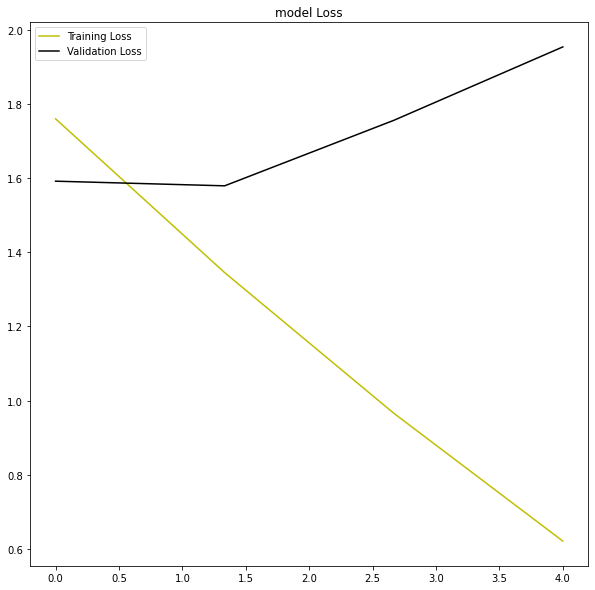

In [ ]:
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))
plt.plot(valid_x, validation_loss_logger, c = "k")

plt.title("model Loss")
plt.legend(["Training Loss", "Validation Loss"])

In [ ]:
# to do
# mask input - partially done
# see training is working - done
# see validation is working - done
# test - done
# run on GPU - done
# save original model - done
# save the best model - done
# add progress bar - done
# combine train and validate - done
# plot loss - done
# run on massive

## Test the output by visualising it

In [ ]:
# test with user input
# visualise output 

# https://ramsrigoutham.medium.com/sized-fill-in-the-blank-or-multi-mask-filling-with-roberta-and-huggingface-transformers-58eb9e7fb0c

def get_prediction (sent):
    
    token_ids = tokenizer.encode(sent, return_tensors='pt')
    masked_position = (token_ids.squeeze() == tokenizer.mask_token_id).nonzero()
    masked_pos = [mask.item() for mask in masked_position ]

    model.eval
    with torch.no_grad():
        output = model(token_ids)

    last_hidden_state = output[0].squeeze()

    list_of_list =[]
    for index,mask_index in enumerate(masked_pos):
        mask_hidden_state = last_hidden_state[mask_index]
        idx = torch.topk(mask_hidden_state, k=5, dim=0)[1]
        words = [tokenizer.decode(i.item()).strip() for i in idx]
        list_of_list.append(words)
        print ("Mask ",index+1,"Guesses : ",words)
    
    best_guess = ""
    for j in list_of_list:
        best_guess = best_guess+" "+j[0]
        
    return best_guess



In [ ]:
sentence = "___ New ___ ___ ___ cute little ___ at ___ ___"
label = "on New Years Day a cute little pilgrim at the gate"

print ("Original Sentence: ",sentence)
print ("label: ",label)
sentence = sentence.replace("___","<mask>")
#print ("Original Sentence replaced with mask: ",sentence)
print ("\n")

# run prediction for original model and trained model
model = torch.load(path_original)
model = model.to('cpu')
predicted_blanks = get_prediction(sentence)
print ("Before train: Best guess for fill in the blank: ",predicted_blanks)
print ("\n")
model = torch.load(path_train)
model = model.to('cpu')
predicted_blanks = get_prediction(sentence)
print ("\n")
print("After train: Best guess for fill in the blank: ",predicted_blanks)


Original Sentence:  ___ New ___ ___ ___ cute little ___ at ___ ___
label:  on New Years Day a cute little pilgrim at the gate


Mask  1 Guesses :  ['The', 'A', 'Brand', 'Meet', 'In']
Mask  2 Guesses :  ['York', 'Yorkers', 'Orleans', 'Yorker', 'Jersey']
Mask  3 Guesses :  ['has', 'finds', 'found', 'launches', 'have']
Mask  4 Guesses :  ['a', 'the', 'this', 'these', "'s"]
Mask  5 Guesses :  ['girl', 'puppies', 'boy', 'puppy', 'baby']
Mask  6 Guesses :  ['the', 'her', 'their', 'his', 'a']
Mask  7 Guesses :  ['party', 'wedding', 'zoo', 'event', 'mall']
Before train: Best guess for fill in the blank:   The York has a girl the party


Mask  1 Guesses :  ['on', 'in', 'by', 'a', 'the']
Mask  2 Guesses :  ['Years', 'Year', 'Day', 'Month', 'Japan']
Mask  3 Guesses :  ['presents', 'gifts', 'Day', 'pine', 'charm']
Mask  4 Guesses :  ['a', 'this', 'the', 'such', 'digs']
Mask  5 Guesses :  ['house', 'pine', 'gate', 'tree', 'hut']
Mask  6 Guesses :  ['the', 'my', 'your', 'his', 'our']
Mask  7 Guesses

In [ ]:
sentence = "wildflowers ___ full ___ ___ ___ fan"
label = "wildflowers at full bloom her paper fan"

print ("Original Sentence: ",sentence)
print ("label: ",label)
sentence = sentence.replace("___","<mask>")
#print ("Original Sentence replaced with mask: ",sentence)
print ("\n")

# run prediction for original model and trained model
model = torch.load(path_original)
model = model.to('cpu')
predicted_blanks = get_prediction(sentence)
print ("Before train: Best guess for fill in the blank: ",predicted_blanks)
print ("\n")
model = torch.load(path_train)
model = model.to('cpu')
predicted_blanks = get_prediction(sentence)
print ("\n")
print("After train: Best guess for fill in the blank: ",predicted_blanks)


Original Sentence:  wildflowers ___ full ___ ___ ___ fan
label:  wildflowers at full bloom her paper fan


Mask  1 Guesses :  ['in', 'go', 'at', ',', 'on']
Mask  2 Guesses :  ['bloom', 'circle', 'moon', '-', 'of']
Mask  3 Guesses :  ['by', 'of', 'from', 'to', 'with']
Mask  4 Guesses :  ['a', 'the', 'by', 'one', 'devoted']
Before train: Best guess for fill in the blank:   in bloom by a


Mask  1 Guesses :  ['in', 'on', 'the', 'at', 'in']
Mask  2 Guesses :  ['bloom', 'eclipse', 'flower', 'of', 'ranger']
Mask  3 Guesses :  ['the', 'a', 'of', 'an', 'on']
Mask  4 Guesses :  ['paper', 'the', 'a', 'his', 'my']


After train: Best guess for fill in the blank:   in bloom the paper


In [ ]:
sentence = "___  ___ ___ house ___ ___ ___ spring ___ today"
label = "amazing  in the house I was born spring begins today"

print ("Original Sentence: ",sentence)
print ("label: ",label)
sentence = sentence.replace("___","<mask>")
#print ("Original Sentence replaced with mask: ",sentence)
print ("\n")

# run prediction for original model and trained model
model = torch.load(path_original)
model = model.to('cpu')
predicted_blanks = get_prediction(sentence)
print ("Before train: Best guess for fill in the blank: ",predicted_blanks)
print ("\n")
model = torch.load(path_train)
model = model.to('cpu')
predicted_blanks = get_prediction(sentence)
print ("\n")
print("After train: Best guess for fill in the blank: ",predicted_blanks)

Original Sentence:  ___  ___ ___ house ___ ___ ___ spring ___ today
label:  amazing  in the house I was born spring begins today


Mask  1 Guesses :  ['</s>', 'The', 'A', 'This', 'How']
Mask  2 Guesses :  ['The', 'A', "'s", 'to', 'a']
Mask  3 Guesses :  ['your', 'the', "'s", 'a', 'open']
Mask  4 Guesses :  ['warming', 'is', 'to', 'will', 'in']
Mask  5 Guesses :  ['for', 'the', 'a', 'in', 'to']
Mask  6 Guesses :  ['for', 'the', 'a', 'in', 'with']
Mask  7 Guesses :  ['time', 'sunshine', 'weather', 'cleaning', 'day']
Best guess for fill in the blank:   </s> The your warming for for time


Mask  1 Guesses :  ['my', 'in', 'at', 'living', 'home']
Mask  2 Guesses :  ['at', 'in', 'my', 'the', 'by']
Mask  3 Guesses :  ['my', 'our', 'mountain', 'smoke', 'ones']
Mask  4 Guesses :  ['has', 'is', 'in', 'teaches', 'at']
Mask  5 Guesses :  ['a', 'the', 'in', 'my', 'at']
Mask  6 Guesses :  ['in', 'wife', 'of', 'it', 'to']
Mask  7 Guesses :  ['again', 'rain', 'of', 'frost', 'begins']


After train: Bes